**Natural Language Processing**

Vinayak Gupta 18th May 2021

I have built a basic RNN, GRU and LSTM from scratch using nn.Module functions.
I have illustrated everything from scratch so if you are new to NLP. This would really help you get a good understanding of how RNN and LSTMs work.

I'll provide brief explanations and links for further reading wherever I can :)


**Dataset Download**

The dataset can be downloaded here https://download.pytorch.org/tutorial/data.zip


**Special note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.


In [1]:
# Dependencies

import io
import os 
import unicodedata
import string
import glob

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import random

**Mounting the Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Text Classification**

We are doing Name Classfication where given a input name of a person, the model predicts the place from where he is from.

Example: 

Input: Vladimir

Output: Russian

We are creating a string which contains all the letters from a to z in both lowercase and uppercase and including few special characters like .,:'

In [3]:
# alphabet small + capital letters + ".,:"
ALL_LETTERS = string.ascii_letters + " .,:'"
N_LETTERS = len(ALL_LETTERS)
print(ALL_LETTERS)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,:'


#**Data Refinement**

The function **unicode_to_ascii** converts special characters like Ś and Í to S and I respectively

The function load_data is used to load the data.

We use the glob.glob(path) function to retrieve paths recursively from inside the directories/files 
You can learn more about it from https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/

The function read_lines returns all the names of the person from a specific directory. Here it is filename

**os.path.basename()** is used to get the base name in specified path

**os.path.splitext()** is used to split the path name into a pair root and ext

You can learn more about them from 

os.path.basename: https://www.geeksforgeeks.org/python-os-path-basename-method/

os.path.splitext: https://www.geeksforgeeks.org/python-os-path-splitext-method/


In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )
def load_data():
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('/content/drive/MyDrive/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

# The category_lines is a dictionary which contains the names of person from each respective country
# all_categories is a list which contains the names of all the different country

#**Data Processing**

The function letter_to_index returns the Letter index from the all_letters string, e.g. "a" = 0

The function letter_to_tensor turns the letter into a <1 x n_letters> Tensor like an one-hot encoding

The function line_to_tensor converts a line into a < line_length x 1 x n_letters> / an array of one hot letter vectors

Instead of taking the words in a batch we train it individually i.e we use batch_size = 1. We pick a random training example and train it on that

In [5]:
# Find Letter Index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1,N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a < line_length x 1 x n_letters>
# or an array of one hot letter vectors

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a)-1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


In [7]:
print(unicode_to_ascii('Ślusàrskî'))

category_lines, all_categories = load_data()

print(letter_to_tensor('J'))
print(line_to_tensor('Jonas').size())

Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


We load the data. n_categories is the number of different class labels. n_hidden is the number of layers in the RNN

In [8]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128

#**RNN**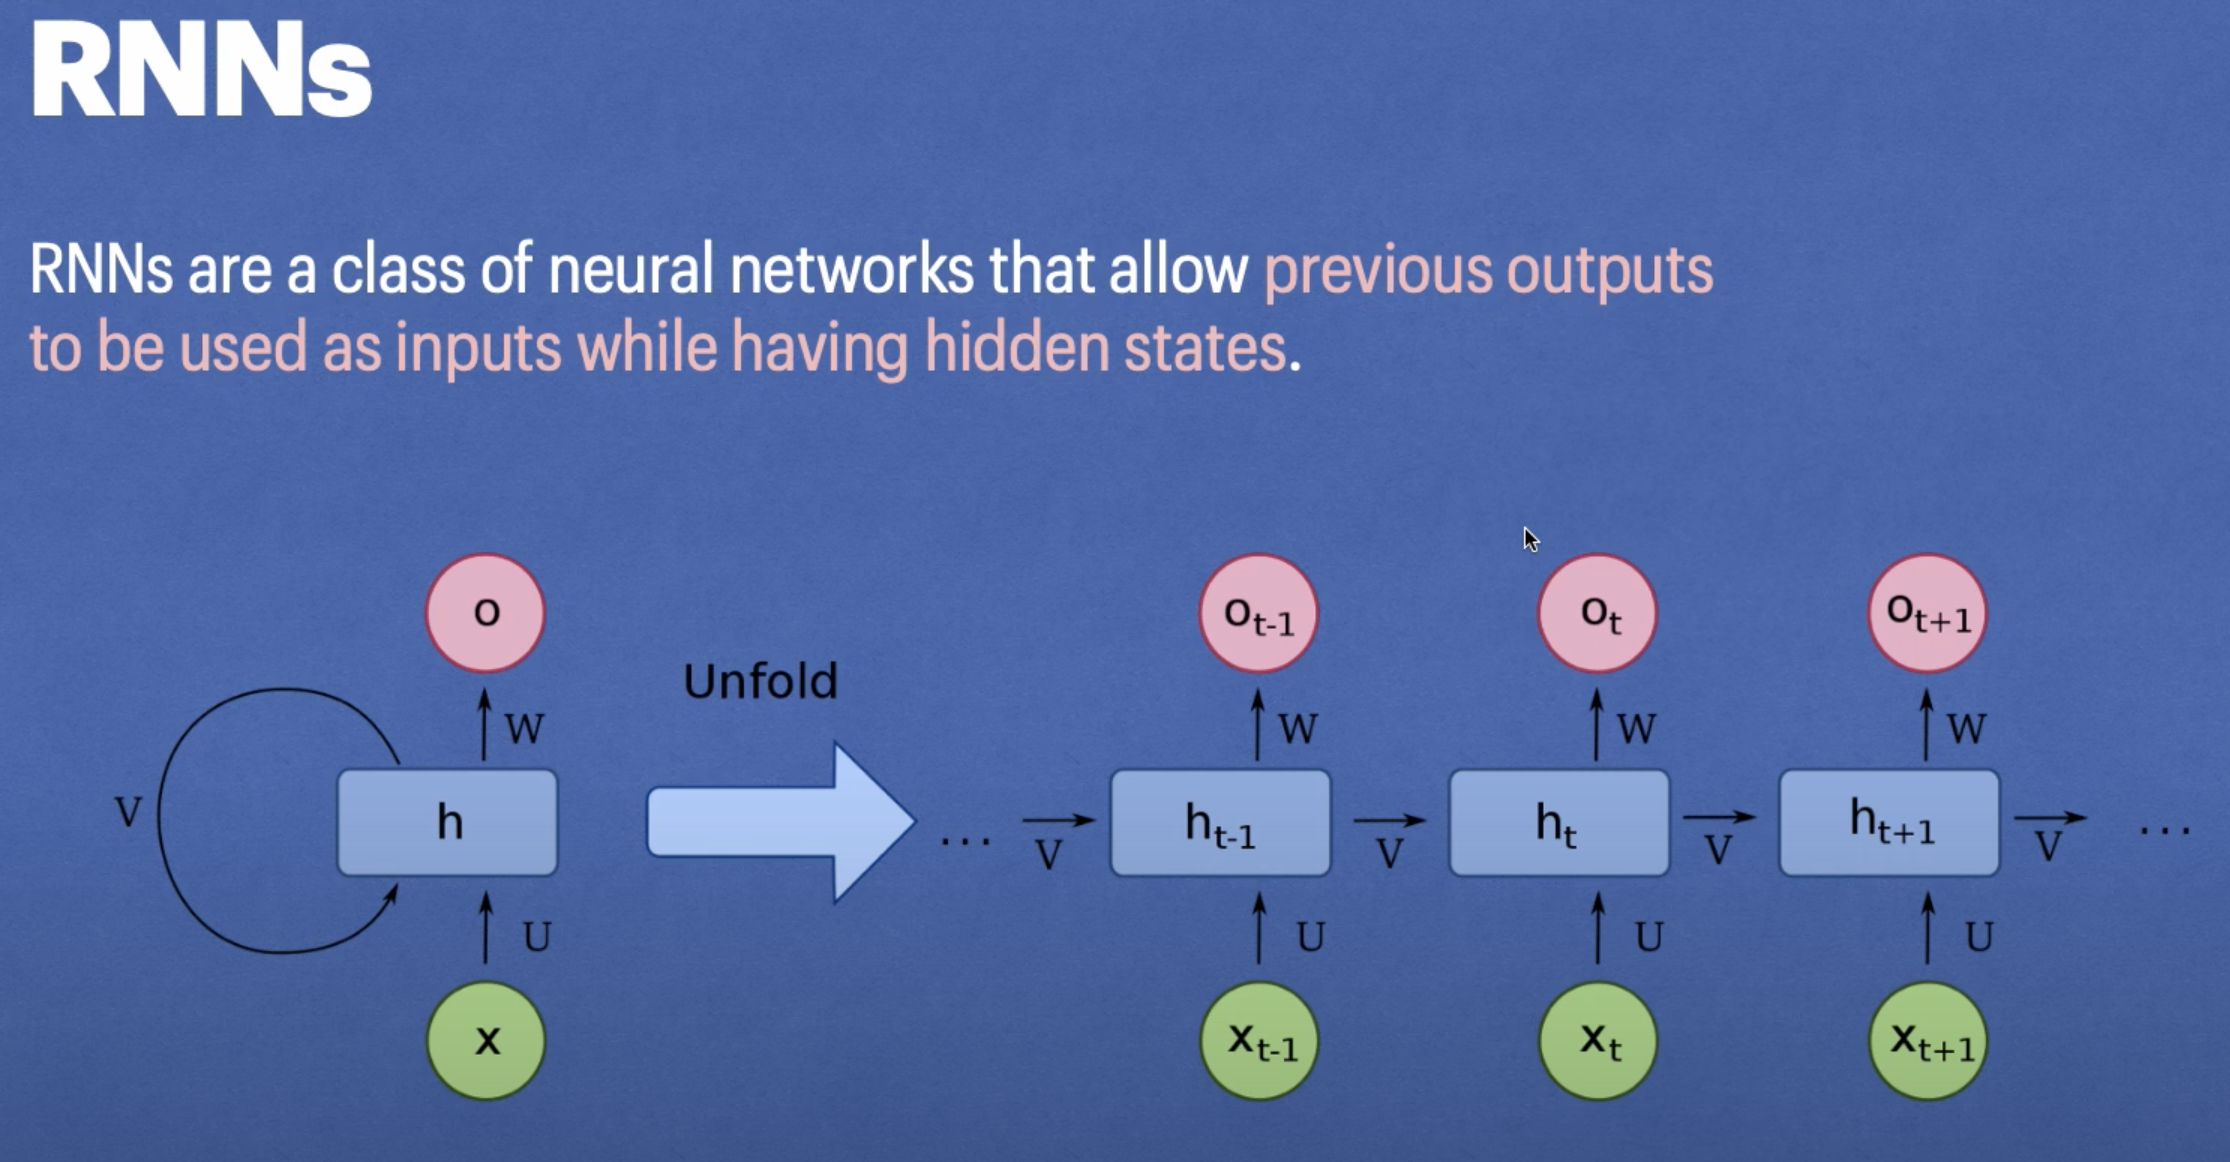

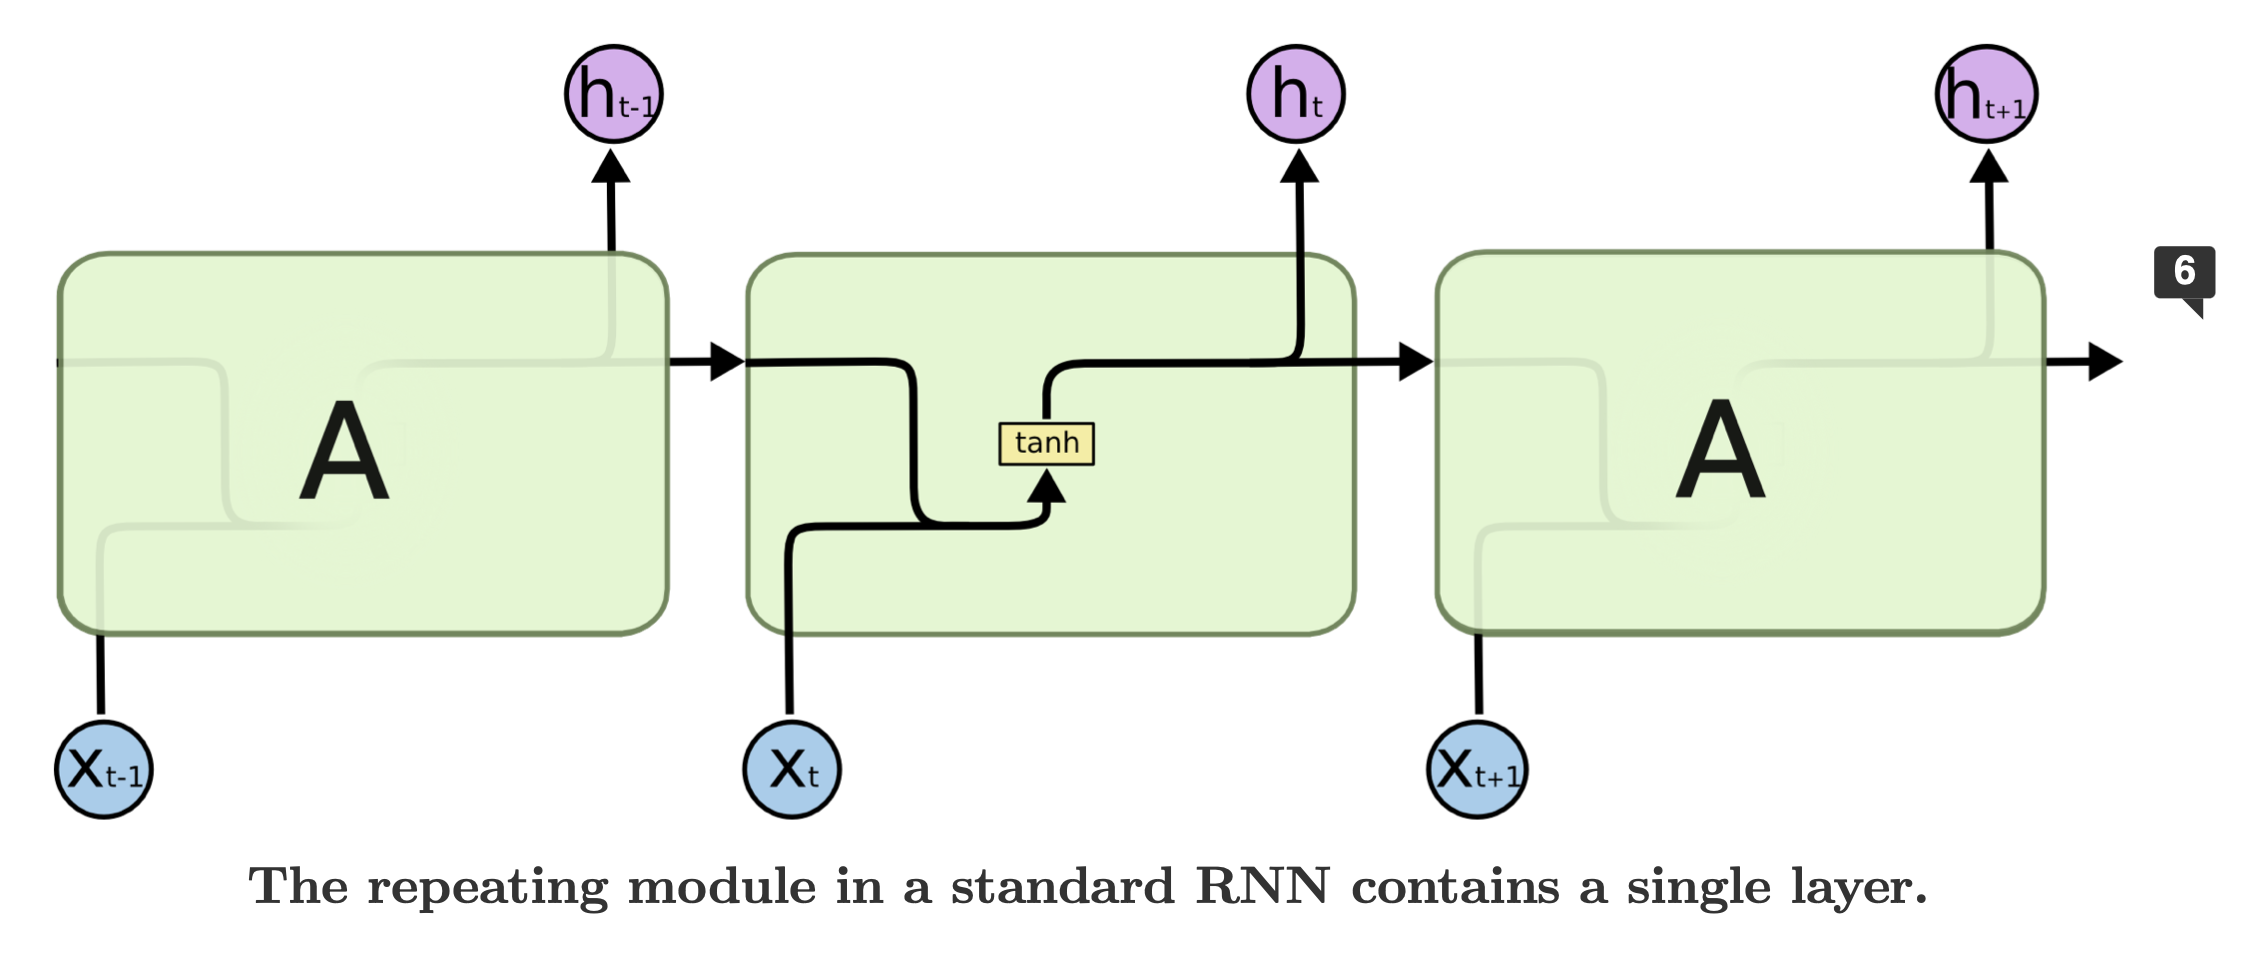

The input X(t-1), X(t) are encodings of letters into vector and they are input for the RNN. The input is given sequential i.e We can calculate h(t) only if h(t-1) has been calculated. RNN's are used for various tasks like Sentiment analysis, Language translation and many more.
In Sentiment analysis it is a many to one case where the words as input give a single output a number(which may be 0 or 1 on how bad or good a person's mood is)



In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.tanh(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

rnn = RNN(N_LETTERS, n_hidden, n_categories)

RNNs are bad at using the past information. They are not able to remember the past information and hence due to this they lose many important past information

Because of this LSTMs were introduced

#**LSTM**



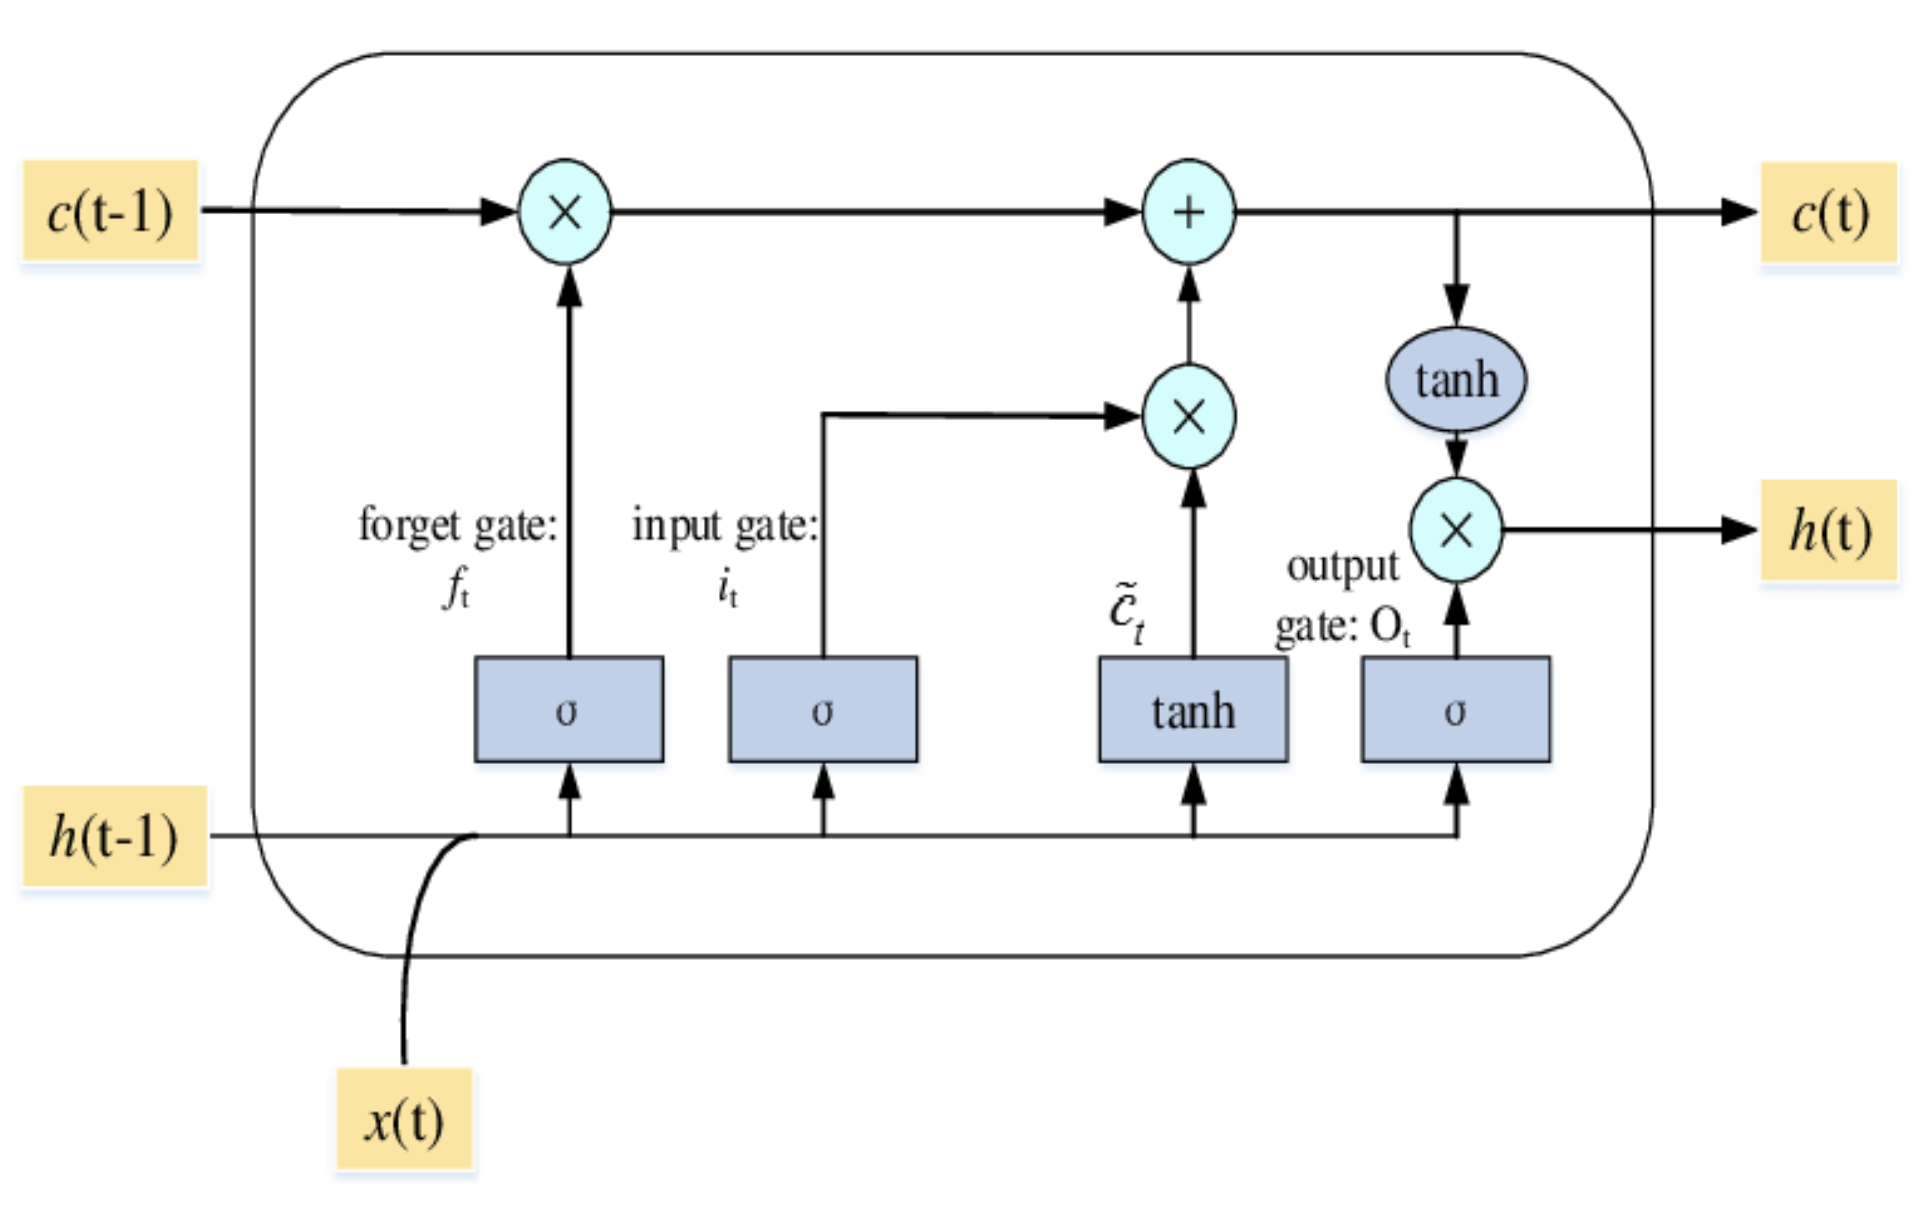

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

To read more about LSTMs check out this article: [link text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.i2f = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2i = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2c = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, hidden_size)
        self.yhat = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor, long_term_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        f = self.i2f(combined)
        f = self.sigmoid(f)
        i = self.i2i(combined)
        i = self.sigmoid(i)
        c = self.i2c(combined)
        c = self.tanh(c)
        Ct = f*long_term_tensor + i*c
        Ct = self.tanh(Ct)
        o = self.i2o(combined)
        o = self.sigmoid(o)
        hidden = o*Ct
        output = self.yhat(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

    def init_long_term(self):
        return torch.zeros(1, self.hidden_size)

lstm = LSTM(N_LETTERS, n_hidden, n_categories)

#**GRU**



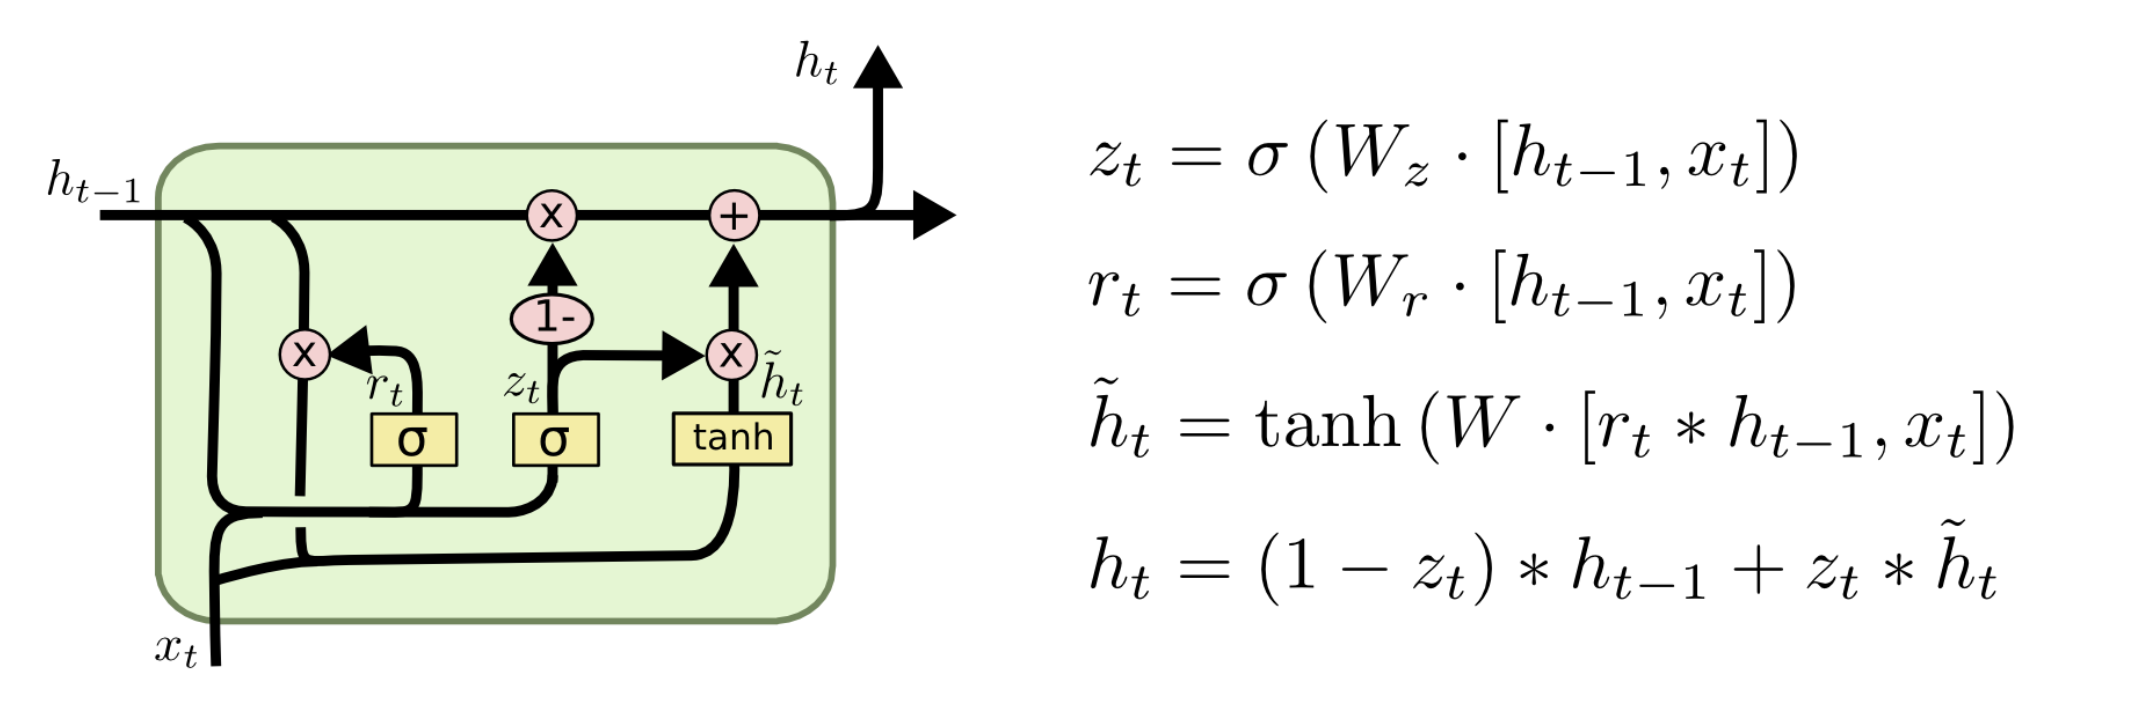

A slightly more dramatic variation on the LSTM is the Gated Recurrent Unit, or GRU. It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models, and has been growing increasingly popular

In [ ]:
class GRU(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        self.i2u = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2r = nn.Linear(input_size + hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.hidden_next = nn.Linear(input_size + hidden_size, hidden_size)
        self.yhat = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        z = self.i2u(combined)
        z = self.sigmoid(z)
        r = self.i2r(combined)
        r = self.sigmoid(z)
        reset = r*hidden_tensor
        combined = torch.cat((input_tensor, reset), 1)
        hidden_bar = self.hidden_next(combined)
        hidden_bar = self.tanh(hidden_bar)
        hidden = (1-z)*hidden_tensor + z*hidden_bar
        output = self.yhat(hidden)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

gru = GRU(N_LETTERS, n_hidden, n_categories)

#**Training the model**

Alright, let's train the model now. We randomly choose a training sample and we use that as a batch(with batch_size = 1) and train on it(like SGD)

Here I am using LSTM model to train, but you can use any architecture. Just change the word lstm to gru or rnn based on your choice in the code below. 

Note : If you are going to use GRU or RNN then remove the long_term_tensor line in the code below since we need that only for LSTM

5000 1.7 3.6624 Walentowicz / Spanish WRONG (Polish)  Accuracy: 0.3396
10000 3.3 0.0286 Kajitani / Japanese CORRECT  Accuracy: 0.5098
15000 5.0 0.5002 Smets / Dutch CORRECT  Accuracy: 0.588
20000 6.7 3.3580 Rumpade / French WRONG (Dutch)  Accuracy: 0.6342
25000 8.3 0.4466 Alberighi / Italian CORRECT  Accuracy: 0.6866
30000 10.0 2.1694 Delaney / English WRONG (Irish)  Accuracy: 0.735
35000 11.7 0.0022 Kozlowski / Polish CORRECT  Accuracy: 0.777
40000 13.3 0.4827 Kirchma / Czech CORRECT  Accuracy: 0.796
45000 15.0 4.2470 Mann / Chinese WRONG (German)  Accuracy: 0.8038
50000 16.7 0.0049 Sapienti / Italian CORRECT  Accuracy: 0.8272
55000 18.3 2.8004 Momdjyan / German WRONG (Russian)  Accuracy: 0.8418
60000 20.0 0.1356 Demas / Greek CORRECT  Accuracy: 0.8498
65000 21.7 0.8756 Dam / Vietnamese CORRECT  Accuracy: 0.846
70000 23.3 3.6406 Basurto / Portuguese WRONG (Italian)  Accuracy: 0.8644
75000 25.0 0.2744 Fonseca / Portuguese CORRECT  Accuracy: 0.8614
80000 26.7 0.0895 Snider / Dutch CORRE

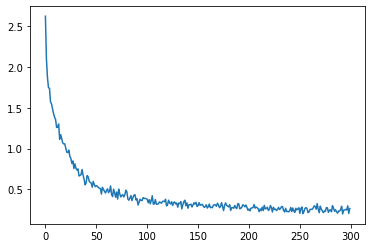

In [17]:
criterion = nn.NLLLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

def train(line_tensor, category_tensor):
    hidden = lstm.init_hidden()
    long_term_tensor = lstm.init_long_term()
    for i in range(line_tensor.size()[0]):
        output, hidden = lstm(line_tensor[i], hidden, long_term_tensor)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 300000
accuracy = 0

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    guess = category_from_output(output)
    if guess == category:
        accuracy = accuracy + 1 
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT"if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100:.1f} {loss:.4f} {line} / {guess} {correct}  Accuracy: {accuracy/5000}")
        accuracy = 0

plt.figure()
plt.plot(all_losses)
plt.show()


To predict the place of origin of a new name use the predict function below

In [23]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = lstm.init_hidden()
        long_term_tensor = lstm.init_long_term()

        for i in range(line_tensor.size()[0]):
            output, hidden = lstm(line_tensor[i], hidden, long_term_tensor)

        guess = category_from_output(output)
        print(guess)
predict('Kofran')


> Kofran
Czech


There you go!!!

We have succesfully coded and trained RNN, LSTM and GRU from scratch. This would have given you a nice understanding on how the model works.

The dataset is not that good so if you give a completely different name then the model will have a tough time recognising it. However, this was meant to be a primer and fun project.